train = pd.read_csv('G:\\My Drive\\Development\\DATA_unchanged\\DATE\\train.csv')
test = pd.read_csv('G:\\My Drive\\Development\\DATA_unchanged\\DATE\\test.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit

# Load the dataset
df = pd.read_csv("train.csv")

# Filter out rows where trip duration is over 1000 seconds
df = df[df['trip_duration'] <= 1999]


# Calculate distance for each trip using the haversine library
df['distance_km'] = df.apply(lambda row: haversine(
    (row['pickup_latitude'], row['pickup_longitude']), 
    (row['dropoff_latitude'], row['dropoff_longitude']),
    unit=Unit.KILOMETERS), axis=1)

# Convert pickup_datetime column to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract date and hour from pickup_datetime
df['pickup_date_hour'] = df['pickup_datetime'].dt.strftime('%Y-%m-%d %H')

# Define time periods
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Mor'
    elif 12 <= hour < 17:
        return 'An'
    elif 17 <= hour < 20:
        return 'Eve'
    else:
        return 'Night'

# Add a new column for time period
df['time_period'] = df['pickup_datetime'].dt.hour.apply(get_time_period)

# Define start and end dates for the window
start_date = '2016-01-01'
end_date = '2016-01-16'  # Example: Window for the first half of 2016
      
# Filter the dataset based on the defined window
df_window = df[(df['pickup_datetime'] >= start_date) & (df['pickup_datetime'] <= end_date)]

# Group by date and time period and calculate average trip duration and distance
trip_stats_by_period = df_window.groupby([df_window['pickup_datetime'].dt.date, 'time_period']).agg({
    'trip_duration': 'mean',
    'distance_km': 'mean'
}).reset_index()

# Define the order of time periods
time_period_order = ['Mor', 'An', 'Eve', 'Night']

# Convert 'time_period' to a categorical type with the specified order
trip_stats_by_period['time_period'] = pd.Categorical(trip_stats_by_period['time_period'], categories=time_period_order, ordered=True)

# Sort the dataframe by date and time period
trip_stats_by_period = trip_stats_by_period.sort_values(by=['pickup_datetime', 'time_period'])

# Plot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Create a list of dates for the x-axis
dates = trip_stats_by_period['pickup_datetime'].astype(str) + ' ' + trip_stats_by_period['time_period'].astype(str)

color = 'tab:red'
ax1.set_xlabel('Date-Time Period')
ax1.set_ylabel('Average Trip Duration in seconds', color=color)
ax1.plot(dates, trip_stats_by_period['trip_duration'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Trip Distance in km', color=color)
ax2.plot(dates, trip_stats_by_period['distance_km'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Average Taxi Trip Duration and Distance by Time Period \n{start_date} to {end_date}')
plt.xticks(rotation=45)
ax1.set_xticklabels(dates, rotation=90)
plt.grid(True)
plt.show()


In [ ]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a list of dates with day of the week for the x-axis
dates_with_day = trip_stats_by_period['pickup_date'].apply(lambda x: x.strftime('%m-%d')) +' | '+ trip_stats_by_period['pickup_day_of_week'] +' | '+ trip_stats_by_period['time_period'].astype(str)

color = 'tab:red'
ax1.set_xlabel('Date-Time Period')
ax1.set_ylabel('Average Trip Duration (seconds)', color=color)
ax1.plot(dates_with_day, trip_stats_by_period['trip_duration'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Trip Distance (km)', color=color)
ax2.plot(dates_with_day, trip_stats_by_period['distance_km'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Average Taxi Trip Duration and Distance by Time Period \n{start_date} to {end_date}')
plt.xticks(rotation=45)
ax1.set_xticklabels(dates_with_day, rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# Amount of rides by time period
# Filter the dataset based on the defined window
df_window = df[(df['pickup_datetime'] >= start_date) & (df['pickup_datetime'] <= end_date)]

# Group by time period and count the number of rides
ride_counts_by_time_period = df_window.groupby('time_period').size().reindex(['Morning', 'Afternoon', 'Evening', 'Night']).reset_index(name='ride_count')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for the number of rides
ax.bar(ride_counts_by_time_period['time_period'], ride_counts_by_time_period['ride_count'], color='tab:blue')
ax.set_xlabel('Time Period')
ax.set_ylabel('Number of Rides')
ax.set_title(f'Number of Taxi Rides by Time Period \n{start_date} to {end_date}')
ax.grid(True)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to calculate distance between two points using Haversine formula
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = 6371 * c  # Radius of the Earth in kilometers
    return distance

# Load the training dataset
train_df = pd.read_csv("train.csv")

# Preprocess the training data
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])

train_df['pickup_date_hour'] = train_df['pickup_datetime'].dt.strftime('%Y-%m-%d %H')

train_df['distance_km'] = train_df.apply(lambda row: haversine_distance(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Feature engineering
train_df['pickup_day'] = train_df['pickup_datetime'].dt.day
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday

# Remove outliers where trip duration is over 4000 seconds
train_df = train_df[(train_df['trip_duration'] <= 4000) & (train_df['trip_duration'] > 0)]

# Define features and target variable
features = ['vendor_id', 'passenger_count', 'distance_km', 'pickup_day', 'pickup_hour', 'pickup_weekday']
X = train_df[features]
y = train_df['trip_duration']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse}")

# Load the test dataset
test_df = pd.read_csv("test.csv")

# Preprocess the test data
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['pickup_date_hour'] = test_df['pickup_datetime'].dt.strftime('%Y-%m-%d %H')

test_df['distance_km'] = test_df.apply(lambda row: haversine_distance(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Feature engineering
test_df['pickup_day'] = test_df['pickup_datetime'].dt.day
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_weekday'] = test_df['pickup_datetime'].dt.weekday

# Prepare the test data features
X_test = test_df[features]

# Make predictions on the test data
test_df['predicted_trip_duration'] = model.predict(X_test)

# Save predictions to a CSV file
submission = test_df[['id', 'predicted_trip_duration']]
submission.columns = ['id', 'trip_duration']
submission.to_csv('submission.csv', index=False)


In [ ]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Exponential smoothing function
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

# Function to plot exponential smoothing
def plotExponentialSmoothing(series, alphas):
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
    plt.plot(series.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
    plt.show()


 # Plot exponential smoothing for average trip duration and distance
plotExponentialSmoothing(trip_stats_by_date_hour_filtered['trip_duration'], [0.3, 0.5])
plotExponentialSmoothing(trip_stats_by_date_hour_filtered['distance_km'], [0.3, 0.5])   

In [ ]:

# Group by time period and calculate average trip duration and distance
trip_stats_by_time_period = df_window.groupby('time_period').agg({
    'trip_duration': 'mean',
    'distance_km': 'mean'
}).reindex(['Morning', 'Afternoon', 'Evening', 'Night']).reset_index()

# Plot the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Histogram for average trip duration
ax1.bar(trip_stats_by_time_period['time_period'], trip_stats_by_time_period['trip_duration'], color='tab:red')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Average Trip Duration in seconds')
ax1.set_title('Average Taxi Trip Duration by Time Period \n{start_date} to {end_date}'.format(start_date=start_date, end_date=end_date))
ax1.grid(True)

# Histogram for average trip distance
ax2.bar(trip_stats_by_time_period['time_period'], trip_stats_by_time_period['distance_km'], color='tab:blue')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Average Trip Distance in km')
ax2.set_title('Average Taxi Trip Distance by Time Period \n{start_date} to {end_date}'.format(start_date=start_date, end_date=end_date))
ax2.grid(True)

fig.tight_layout()
plt.show()


C:\Users\andig\AppData\Local\Temp\ipykernel_22688\2263795715.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(dates_with_day, rotation=90)


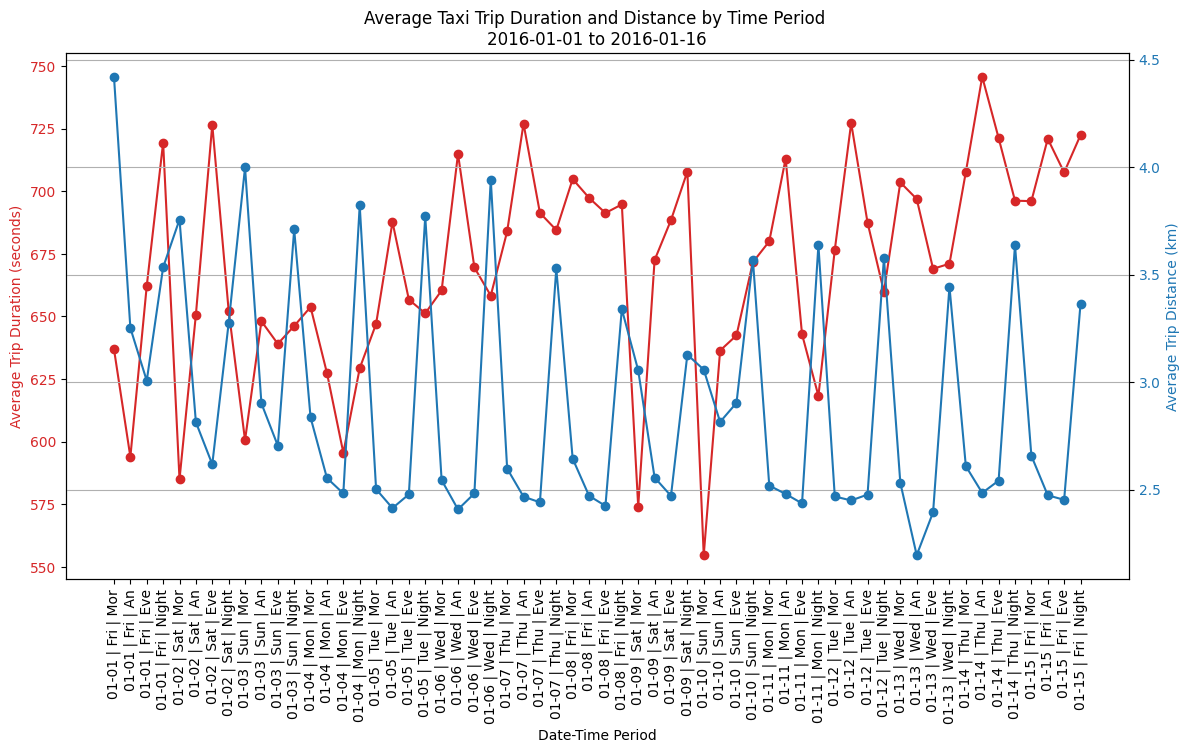

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit

# Load the dataset
df = pd.read_csv("train.csv")

# Filter out rows where trip duration is over 1000 seconds
df = df[df['trip_duration'] <= 1999]

# Calculate distance for each trip using the haversine library
df['distance_km'] = df.apply(lambda row: haversine(
    (row['pickup_latitude'], row['pickup_longitude']), 
    (row['dropoff_latitude'], row['dropoff_longitude']),
    unit=Unit.KILOMETERS), axis=1)

# Convert pickup_datetime column to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract date, hour, and day of the week from pickup_datetime
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['pickup_datetime'].dt.strftime('%a')  # Short weekday name

# Define time periods
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Mor'
    elif 12 <= hour < 17:
        return 'An'
    elif 17 <= hour < 20:
        return 'Eve'
    else:
        return 'Night'

# Add a new column for time period
df['time_period'] = df['pickup_hour'].apply(get_time_period)

# Define start and end dates for the window
start_date = '2016-01-01'
end_date = '2016-01-16'  # Example: Window for the first half of 2016

# Filter the dataset based on the defined window
df_window = df[(df['pickup_datetime'] >= start_date) & (df['pickup_datetime'] <= end_date)]

# Group by date, day of the week, and time period and calculate average trip duration and distance
trip_stats_by_period = df_window.groupby(['pickup_date', 'pickup_day_of_week', 'time_period']).agg({
    'trip_duration': 'mean',
    'distance_km': 'mean'
}).reset_index()

# Define the order of time periods
time_period_order = ['Mor', 'An', 'Eve', 'Night']

# Convert 'time_period' to a categorical type with the specified order
trip_stats_by_period['time_period'] = pd.Categorical(trip_stats_by_period['time_period'], categories=time_period_order, ordered=True)

# Sort the dataframe by date, day of the week, and time period
trip_stats_by_period = trip_stats_by_period.sort_values(by=['pickup_date', 'pickup_day_of_week', 'time_period'])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a list of dates with day of the week for the x-axis
dates_with_day = trip_stats_by_period['pickup_date'].apply(lambda x: x.strftime('%m-%d')) +' | '+ trip_stats_by_period['pickup_day_of_week'] +' | '+ trip_stats_by_period['time_period'].astype(str)

color = 'tab:red'
ax1.set_xlabel('Date-Time Period')
ax1.set_ylabel('Average Trip Duration (seconds)', color=color)
ax1.plot(dates_with_day, trip_stats_by_period['trip_duration'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Trip Distance (km)', color=color)
ax2.plot(dates_with_day, trip_stats_by_period['distance_km'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Average Taxi Trip Duration and Distance by Time Period \n{start_date} to {end_date}')
plt.xticks(rotation=45)
ax1.set_xticklabels(dates_with_day, rotation=90)
plt.grid(True)
plt.show()
